# Customer churn analysis


# Machine Learning Pipeline

In the following notebooks, we will go through the implementation of each one of the steps in the Machine Learning Pipeline. 

We will discuss:

1. Data Preparation and Analysis
2. **Feature Engineering**
3. **Feature Selection**
4. **Model Training**
5. **Obtaining Predictions / Scoring**

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import udf
%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to save the trained scaler class
import joblib

C:\Users\purkol\anaconda3\envs\getting_started_snowpark_python\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Snowflake connection info
from config import snowflake_conn_prop
from snowflake.snowpark import version
print(version.VERSION)

session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(0, 11, 0)
[Row(CURRENT_WAREHOUSE()='WH_UWM', CURRENT_DATABASE()='UWM_HOUSEHOLDING', CURRENT_SCHEMA()='TEAM1_XURAN')]


In [3]:
%%time
raw = session.table('TABLE_FOR_TRAINING').sample(n = 1000)
data = raw.toPandas()

CPU times: total: 297 ms
Wall time: 1.57 s


In [4]:
data.shape

(1000, 23)

# Separate dataset into train and test

It is important to separate our data intro training and testing set. 

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is to avoid over-fitting.

In [5]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

# to divide train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['P1_CONTACT_ID','P2_CONTACT_ID','P1_HOUSEHOLD_ID','P2_HOUSEHOLD_ID','IFFAMILY'], axis=5), # predictive variables
    data['IFFAMILY'], # target
    test_size=0.2, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape,y_train.shape, y_test.shape


((800, 18), (200, 18), (800,), (200,))

## let's identify the different variables

In [6]:
# Since we already cleaned up the data using snowpark, identifying variable is super easy

# we will capture those of type *object*

cat_vars = ['P1_FIRSTNAME', 'P1_MIDDLENAME', 'P1_LASTNAME', 'P2_FIRSTNAME', 'P2_MIDDLENAME', 'P2_LASTNAME',
            'P1_ADDRESS_LINE_1', 'P1_ADDRESS_LINE_2', 'P1_ADDRESS_LINE_3','P2_ADDRESS_LINE_1', 'P2_ADDRESS_LINE_2', 'P2_ADDRESS_LINE_3', 
           'P1_CITY', 'P1_STATE','P1_ZIP','P2_CITY', 'P2_STATE','P2_ZIP']

# we will capture those of type numerical from previous notebook
num_vars = [ ]

features = cat_vars + num_vars
print(features)

['P1_FIRSTNAME', 'P1_MIDDLENAME', 'P1_LASTNAME', 'P2_FIRSTNAME', 'P2_MIDDLENAME', 'P2_LASTNAME', 'P1_ADDRESS_LINE_1', 'P1_ADDRESS_LINE_2', 'P1_ADDRESS_LINE_3', 'P2_ADDRESS_LINE_1', 'P2_ADDRESS_LINE_2', 'P2_ADDRESS_LINE_3', 'P1_CITY', 'P1_STATE', 'P1_ZIP', 'P2_CITY', 'P2_STATE', 'P2_ZIP']


## Numerical variable transformation

In the previous notebook, we observed that the numerical variables are not normally distributed.

We will transform with the MinMaxScaler in order to get a more Gaussian-like distribution. Use ordinal encoding for the categorical variables and check for nulls


In [7]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

['P1_MIDDLENAME', 'P1_ADDRESS_LINE_2', 'P2_MIDDLENAME', 'P2_ADDRESS_LINE_2']

In [8]:
# setup pipeline

#transformations
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

#Classifier
from sklearn.ensemble import RandomForestClassifier

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

#Model Accuracy
from sklearn.metrics import balanced_accuracy_score

# Model Pipeline
ord_pipe = make_pipeline(
    FunctionTransformer(lambda x: x.astype(str)) ,
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    )

num_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),
    MinMaxScaler()
    )

clf = make_pipeline(RandomForestClassifier(random_state=0, n_jobs=-1))

model = make_pipeline(ord_pipe, num_pipe, clf)

# fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function <lambda> at 0x00000236FBE56D30>)),
                                 ('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1))])),
                ('pipeline-2',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('pipeline-3',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(n_jobs=-1,
                                                         random_state=0))]))])

## Check Accuracy of our model on test dataset

In [9]:
y_pred = model.predict_proba(X_test)[:,1]
predictions = [str(round(value))for value in y_pred]
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print("Model testing completed.\n   - Model Balanced Accuracy: %.2f%%" % (balanced_accuracy * 100.0))

Model testing completed.
   - Model Balanced Accuracy: 84.35%


## Confusion Matrix

In [10]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  9
False Positive(FP) =  1
True Negative(TN)  =  186
False Negative(FN) =  4
Accuracy of the classification = 0.975


## Check for important features

Text(0.5, 0, 'Feature Importance')

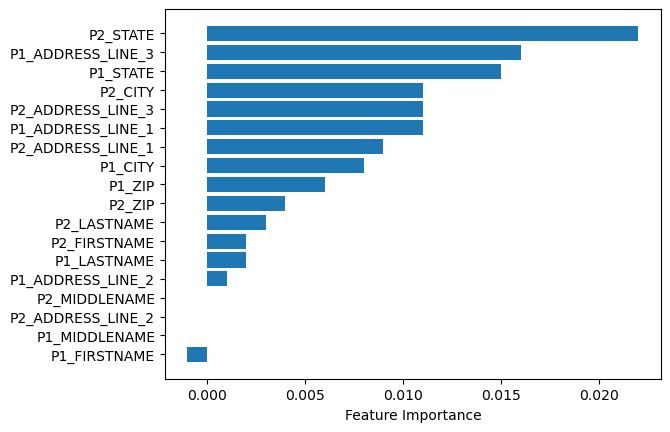

In [11]:
# Feature importance
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(np.array(X_test.columns)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

## Prepare for model deployment in Snowflake using Snowpark Python UDF

In [12]:
#Let's first create a stage to store the artifacts
print(session.sql('create stage if not exists MODELSTAGE').collect())

[Row(status='MODELSTAGE already exists, statement succeeded.')]


### We will define a snopark python UDF to help us score the live data using the model that we built earlier. 

Since we have fitted the model with the scikit learn pipeline, our UDF will do the transformations and also score the new data

In [13]:
%%time

features = list(X_train.columns)

session.add_packages("scikit-learn==1.0.2", "pandas", "numpy")

@udf(name='predict_churn',is_permanent = True, stage_location = '@MODELSTAGE', replace=True)
def predict_churn(args: list) -> float:
    row = pd.DataFrame([args], columns=features)
    return model.predict(row)



CPU times: total: 312 ms
Wall time: 14.3 s


In [14]:
new_df = session.table('TRAIN_DATASET').sample(n = 400)

In [15]:
%%time
new_df.select(new_df.CUSTOMERID,new_df.CHURNVALUE, \
              F.call_udf("predict_churn", F.array_construct(*features)).alias('PREDICTED_CHURN')) \
        .write.mode('overwrite').saveAsTable('churn_detection')


Failed to execute query [queryID: 01a80c6b-0000-ce1e-0001-6aea000dbb56]  CREATE  OR  REPLACE    TABLE  churn_detection AS  SELECT  *  FROM ( SELECT "CUSTOMERID", "CHURNVALUE", predict_churn(array_construct("P1_FIRSTNAME", "P1_MIDDLENAME", "P1_LASTNAME", "P1_ADDRESS_LINE_1", "P1_ADDRESS_LINE_2", "P1_ADDRESS_LINE_3", "P1_CITY", "P1_STATE", "P1_ZIP", "P2_FIRSTNAME", "P2_MIDDLENAME", "P2_LASTNAME", "P2_ADDRESS_LINE_1", "P2_ADDRESS_LINE_2", "P2_ADDRESS_LINE_3", "P2_CITY", "P2_STATE", "P2_ZIP")) AS "PREDICTED_CHURN" FROM ( SELECT  *  FROM ( SELECT  *  FROM (TRAIN_DATASET)) SAMPLE (400 ROWS )))
000904 (42000): SQL compilation error: error line 1 at position 133
invalid identifier 'P1_FIRSTNAME'


SnowparkSQLException: (1304): 000904 (42000): SQL compilation error: error line 1 at position 133
invalid identifier 'P1_FIRSTNAME'

In [16]:
session.table('churn_detection').toPandas()

,CUSTOMERID,CHURNVALUE,PREDICTED_CHURN
0,2065-zGaF6,0.0,0.0
1,9470-FBYq4,1.0,1.0
2,5448-myy2Q,0.0,0.0
3,3505-jtuHB,0.0,0.0
4,8125-kZ7Wh,1.0,1.0
...,...,...,...
395,1072-92erh,0.0,0.0
396,4837-R51JW,1.0,1.0
397,1567-Gt7oP,1.0,1.0
398,9702-WmqAB,0.0,0.0


## Different Syntax to register the prediction UDF for deployment

In [17]:
%%time
session.add_packages("scikit-learn==1.0.2", "pandas", "numpy")
features = list(X_train.columns)
predict_churn_model = session.udf.register(lambda *args: 
                                    model.predict(pd.DataFrame(args, columns=features)),
                                    name="predict_churn_model",
                                    stage_location="@MODELSTAGE",
                                    return_type=FloatType(),
                                    is_permanent=True,
                                    replace=True,
                                    input_types=[ArrayType()])

CPU times: total: 109 ms
Wall time: 5.83 s


## if we want to do the prediction using SQL

In [18]:
%%time
session.sql(' select customerid,churnvalue, \
            predict_churn(ARRAY_CONSTRUCT( \
                                    GENDER, \
                                    COUNT, \
                                    SENIORCITIZEN, \
                                    PARTNER, \
                                    DEPENDENTS, \
                                    PHONESERVICE, \
                                    MULTIPLELINES,  \
                                    INTERNETSERVICE,  \
                                    ONLINESECURITY,  \
                                    ONLINEBACKUP, \
                                    DEVICEPROTECTION,  \
                                    TECHSUPPORT,  \
                                    STREAMINGTV,  \
                                    STREAMINGMOVIES, \
                                    CONTRACT,  \
                                    PAPERLESSBILLING,  \
                                    PAYMENTMETHOD,  \
                                    TENUREMONTHS, \
                                    MONTHLYCHARGES,  \
                                    TOTALCHARGES)) as Churn_prediction \
                                    from train_dataset sample (10 rows)').show()

Failed to execute query [queryID: 01a80c6b-0000-ce1e-0001-6aea000dbb5e]  SELECT  *  FROM ( select customerid,churnvalue,             predict_churn(ARRAY_CONSTRUCT(                                     GENDER,                                     COUNT,                                     SENIORCITIZEN,                                     PARTNER,                                     DEPENDENTS,                                     PHONESERVICE,                                     MULTIPLELINES,                                      INTERNETSERVICE,                                      ONLINESECURITY,                                      ONLINEBACKUP,                                     DEVICEPROTECTION,                                      TECHSUPPORT,                                      STREAMINGTV,                                      STREAMINGMOVIES,                                     CONTRACT,                                      PAPERLESSBILLING,                                      

SnowparkSQLException: (1304): 100357 (P0000): Python Interpreter Error:
Traceback (most recent call last):
  File "/usr/lib/python_udf/9aa80b4b51fabadd884596bb50807052133cdbfc23e765b70f37dc2f747412f8/lib/python3.8/site-packages/pandas/core/internals/construction.py", line 982, in _finalize_columns_and_data
    columns = _validate_or_indexify_columns(contents, columns)
  File "/usr/lib/python_udf/9aa80b4b51fabadd884596bb50807052133cdbfc23e765b70f37dc2f747412f8/lib/python3.8/site-packages/pandas/core/internals/construction.py", line 1030, in _validate_or_indexify_columns
    raise AssertionError(
AssertionError: 18 columns passed, passed data had 20 columns

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/udf/23784036/udf_py_81290025.zip/udf_py_81290025.py", line 31, in compute
    return lock_function_once(func, invoked)(arg1)
  File "/home/udf/23784036/udf_py_81290025.zip/udf_py_81290025.py", line 20, in wrapper
    result = f(*args, **kwargs)
  File "<timed exec>", line 7, in predict_churn
  File "/usr/lib/python_udf/9aa80b4b51fabadd884596bb50807052133cdbfc23e765b70f37dc2f747412f8/lib/python3.8/site-packages/pandas/core/frame.py", line 721, in __init__
    arrays, columns, index = nested_data_to_arrays(
  File "/usr/lib/python_udf/9aa80b4b51fabadd884596bb50807052133cdbfc23e765b70f37dc2f747412f8/lib/python3.8/site-packages/pandas/core/internals/construction.py", line 519, in nested_data_to_arrays
    arrays, columns = to_arrays(data, columns, dtype=dtype)
  File "/usr/lib/python_udf/9aa80b4b51fabadd884596bb50807052133cdbfc23e765b70f37dc2f747412f8/lib/python3.8/site-packages/pandas/core/internals/construction.py", line 883, in to_arrays
    content, columns = _finalize_columns_and_data(arr, columns, dtype)
  File "/usr/lib/python_udf/9aa80b4b51fabadd884596bb50807052133cdbfc23e765b70f37dc2f747412f8/lib/python3.8/site-packages/pandas/core/internals/construction.py", line 985, in _finalize_columns_and_data
    raise ValueError(err) from err
ValueError: 18 columns passed, passed data had 20 columns
 in function PREDICT_CHURN with handler udf_py_81290025.compute

In [19]:
session.close()